In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.animation as animation
%matplotlib inline
%config InlineBackend.figure_format='svg'
plt.rcParams['animation.html'] = 'html5'
import time

# Solving the Navier Stokes Equations Using the Finite Volume Method

In [2]:
nx = 32
ny = nx
ν = 0.01
lx = 1.
ly = 1.
dx = lx/nx
dy = ly/ny

# Boundary conditions on velocity
## All normal velocity components are zero (no inlets)
Ut = 2.
Ub = 0.
Vl = 0.
Vr = 0.

print(f'Re number = {Ut*lx/ν}')

# Choose dt based on the linear advection-diffusion constraint
## dx = dy, so can choose either
dt = min(0.25*dx*dx/ν, 4*ν/Ut/Ut)
print(f'dt = {dt}')

Re number = 200.0
dt = 0.01


In [12]:
# Build the pressure coefficients
Ap = np.zeros((ny+2,nx+2))
Ae = 1./dx/dx*np.ones((ny+2,nx+2))
Aw = 1./dx/dx*np.ones((ny+2,nx+2))
An = 1./dy/dy*np.ones((ny+2,nx+2))
As = 1./dy/dy*np.ones((ny+2,nx+2))

# Set the left wall coefficients
Aw[1:-1,1] = 0.
# Set the right wall coefficients
Ae[1:-1,-2] = 0.
# Set the top wall coefficients
An[-2,1:-1] = 0.
# Set the bottom wall coefficients
As[1,1:-1] = 0.

Ap = -(Aw + Ae + An + As)

In [48]:
def sor_solver(p, A, b, dx, dy):
    pn = np.empty_like(p)
    Ap, Ae, Aw, An, As = A
    it = 0
    err = 1e5
    tol = 1e-8
    maxit = 1000
    β = 1.8
    while err > tol and it < maxit:
        pn = np.copy(p)
        for i in range(1, nx+1):
            for j in range(1, ny+1):
                ap = Ap[j,i]
                ae = Ae[j,i]
                aw = Aw[j,i]
                an = An[j,i]
                as_ = As[j,i]
                rhs = b[j,i] - 1.*(ae*p[j,i+1] + aw*p[j,i-1] + an*p[j+1,i] + as_*p[j-1,i])
                p[j,i] = β*rhs/ap+ (1-β)*p[j,i]
        err = np.linalg.norm(p-pn)
        it += 1
    print(f'SOR solver error: {err}, iterations: {it}')
    return p, err

In [49]:
# Initialize variables
## All arrays will be of the size of the grid plus the outside ghost cells
## Staggered grid to the minus side
u = np.zeros((ny+2,nx+2))
v = np.zeros((ny+2,nx+2))
p = np.zeros((ny+2,nx+2))
ut = np.zeros((ny+2,nx+2))  # u_tilde
vt = np.zeros((ny+2,nx+2))  # v_tilde
prhs = np.zeros_like(p)
nsteps = 10
A = [Ap, Ae, Aw, An, As]
# Start time integration
for n in range(0, nsteps):
    # Set boundary conditions on u
    u[:,1] = 0.                # Left wall
    u[:,-1] = 0.               # Right wall
    u[-1,:] = 2.*Ut - u[-2,:]  # Top wall
    u[0,:] = 2.*Ub - u[1,:]    # Bottom wall
    # Set boundary conditions on v
    v[-1,:] = 0.                # top wall
    v[1,:] = 0.                 # bottom wall
    v[:,0] = 2.*Vl - v[:,1]     # left wall
    v[:,-1] = 2.*Vr - v[:,-2]   # right wall
    # Assemble x-momentum for u_tilde
    ## Interior points only
    for i in range(2,nx+1):
        for j in range(1,ny+1):
            ue = 0.5*(u[j,i+1]+u[j,i])
            uw = 0.5*(u[j,i]+u[j,i-1])
            un = 0.5*(u[j,i]+u[j+1,i])
            us = 0.5*(u[j,i]+u[j-1,i])
            vn = 0.5*(v[j+1,i-1]+v[j+1,i])
            vs = 0.5*(v[j,i-1]+v[j,i])
            convection = -(un*vn-us*vs)/dy - (ue*ue-uw*uw)/dx
            diffusion = ν*( (u[j,i+1]-2.*u[j,i]+u[j,i-1])/dx/dx + (u[j+1,i]-2.*u[j,i]+u[j-1,i])/dy/dy )
            ut[j,i] = u[j,i] + dt*(convection + diffusion)
    # Assemble y-momentum for v_tilde
    ## Interior points only
    for i in range(1,nx+1):
        for j in range(2,ny+1):
            ue = 0.5*(u[j-1,i+1]+u[j,i+1])
            uw = 0.5*(u[j,i]+u[j-1,i])
            ve = 0.5*(v[j,i]+v[j,i+1])
            vw = 0.5*(v[j,i]+v[j,i-1])
            vn = 0.5*(v[j,i]+v[j+1,i])
            vs = 0.5*(v[j,i]+v[j-1,i])
            convection = -(ue*ve-uw*vw)/dx - (vn*vn-vs*vs)/dy
            diffusion = ν*( (v[j,i+1]-2.*v[j,i]+v[j,i-1])/dx/dx + (v[j+1,i]-2.*v[j,i]+v[j-1,i])/dy/dy )
            vt[j,i] = v[j,i] + dt*(convection + diffusion)

    # Compute pressure RHS: prhs = 1/dt * div(ut)
    for i in range(1, nx+1):
        for j in range(1, ny+1):
            prhs[j,i] = (ut[j,i+1]-ut[j,i])/dx + (vt[j+1,i]-vt[j,i])/dy
    prhs /= dt  # this is 1/dt * div(ut)
    
    p, err = sor_solver(p, A, prhs, dx, dy)
    # final time advance u = ut - dt*dpdx
    u[1:-1, 2:-1] = ut[1:-1,2:-1] - dt*(p[1:-1,2:-1]-p[1:-1,1:-2])/dx
    # final time advance v = vt - dt*dpdy
    v[2:-1,1:-1] = vt[2:-1,1:-1] - dt*(p[2:-1,1:-1]-p[1:-2,1:-1])/dy

SOR solver error: 9.965648705406559e-09, iterations: 366
SOR solver error: 9.662947172727212e-09, iterations: 332
SOR solver error: 9.960030344626972e-09, iterations: 324
SOR solver error: 9.559787565368023e-09, iterations: 318
SOR solver error: 9.94456202012837e-09, iterations: 311
SOR solver error: 9.579429730637642e-09, iterations: 306
SOR solver error: 9.941271489296673e-09, iterations: 300
SOR solver error: 9.505892831851178e-09, iterations: 296
SOR solver error: 9.753729236417211e-09, iterations: 291
SOR solver error: 9.67600137022178e-09, iterations: 287


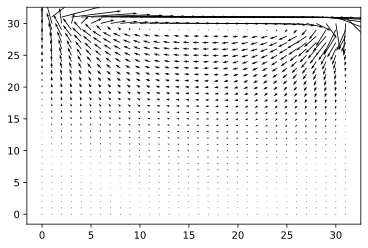

In [50]:
plt.quiver(u[1:-1,1:-1], v[1:-1,1:-1])

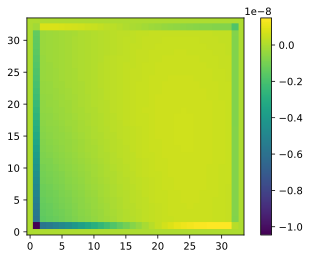

In [51]:
# Compute velocity divergence
divu = np.zeros_like(p)
for i in range(1,nx+1):
    for j in range(1,ny+1):
        divu[j,i] = (u[j,i+1]-u[j,i])/dx + (v[j+1,i]-v[j,i])/dy
plt.imshow(divu, origin='bottom')
plt.colorbar()

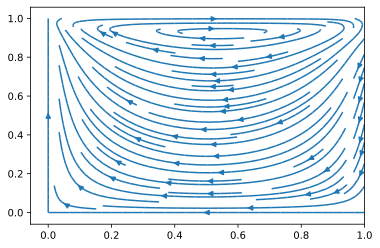

In [56]:
x = np.linspace(0, lx, nx)
y = np.linspace(0, ly, ny)
xx, yy = np.meshgrid(x, y)
plt.streamplot(x, y, u[1:-1,1:-1],v[1:-1,1:-1])

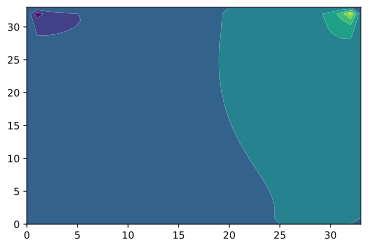

In [57]:
plt.contourf(p)

In [55]:
u.shape

(34, 34)